Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [37]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [38]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/'
# Principales
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'aligned/CUSTOMERt_aligned.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'aligned/PRODUCTSt_aligned.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'aligned/PROMOTION_aligned.csv', encoding='latin-1')
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')


## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [39]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

,ProductKey,OrderDateKey,DueDateKey,ShipDateKey,CustomerKey,PromotionKey,CurrencyKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,310,20101229,20110110,20110105,21768,1,19,6,SO43697,1,...,2171.2942,2171.2942,3578.27,286.2616,89.4568,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
1,346,20101229,20110110,20110105,28389,1,39,7,SO43698,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
2,346,20101229,20110110,20110105,25863,1,100,1,SO43699,1,...,1912.1544,1912.1544,3399.99,271.9992,84.9998,NaN,NaN,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00


### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [40]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

,count,mean,std,min,25%,50%,75%,max
CarrierTrackingNumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerPONumber,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RevisionNumber,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
OrderQuantity,60398.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
UnitPriceDiscountPct,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DiscountAmount,60398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,60398.0,437.557932,118.088390,214.0000,359.0000,479.0000,529.0000,606.0000
CustomerKey,60398.0,18841.685420,5432.430404,11000.0000,14003.0000,18143.0000,23429.7500,29483.0000
PromotionKey,60398.0,1.041839,0.342605,1.0000,1.0000,1.0000,1.0000,14.0000
CurrencyKey,60398.0,69.845326,42.146363,6.0000,19.0000,100.0000,100.0000,100.0000
SalesTerritoryKey,60398.0,6.244462,2.961150,1.0000,4.0000,7.0000,9.0000,10.0000
SalesOrderLineNumber,60398.0,1.886321,1.016328,1.0000,1.0000,2.0000,2.0000,8.0000
UnitPrice,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ExtendedAmount,60398.0,486.086911,928.489892,2.2900,7.9500,29.9900,539.9900,3578.2700
ProductStandardCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942
TotalProductCost,60398.0,286.065657,552.457641,0.8565,2.9733,11.2163,294.5797,2171.2942


La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

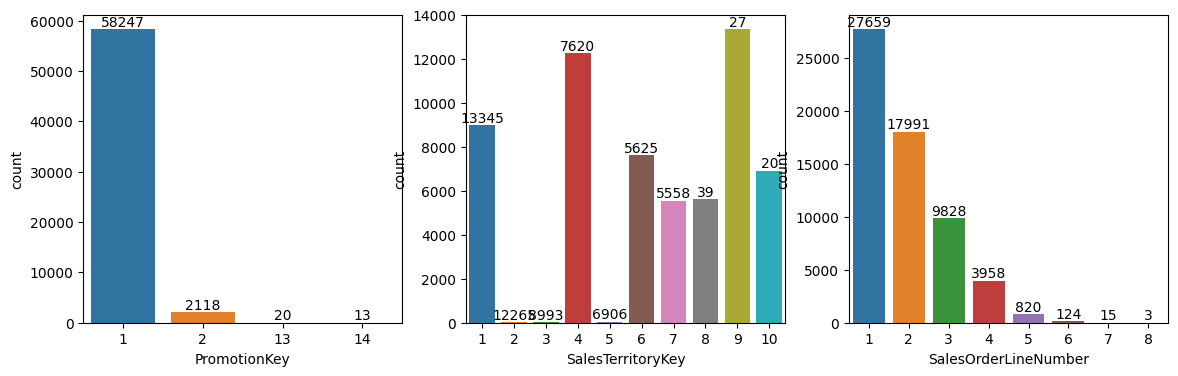

In [42]:
sales = pd.read_csv(myPath + 'cleaned/SALES_clean.csv', encoding='latin-1', \
    parse_dates=['OrderDate', 'DueDate', 'ShipDate'], infer_datetime_format=True)
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = sns.countplot(data = df, ax=axes[0], x='PromotionKey')
abs_values = df['PromotionKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(data= df, ax=axes[1], x='SalesTerritoryKey')
abs_values = df['SalesTerritoryKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(ax=axes[2], x=df['SalesOrderLineNumber'])
abs_values = df['SalesOrderLineNumber'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.
    * ProductKey
    * CustomerKey
    * PromotionKey
    * CurrencyKey
    * SalesTerritoryKey

In [43]:
num_types = sales.dtypes.to_frame('dtypes')
min_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value = sales.describe().T[['min','max']].round(1)
my_summary = pd.concat([num_types, min_col_len, max_col_len, min_max_value], axis=1)
sales_serie = sales['SalesOrderNumber'].str[2:]
# En SalesOrderNumber se ordenan los datos omitiendo 'CO'
min = 'CO'+ str(pd.to_numeric(sales_serie).min())
max = 'CO'+ str(pd.to_numeric(sales_serie).max())
dates = sales[['OrderDate','DueDate','ShipDate']]
my_summary.loc['SalesOrderNumber', ['min','max']] = [min, max]
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'min'] = dates.min()
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'max'] = dates.max()
my_summary

,dtypes,min_length,max_length,min,max
ProductKey,int64,3,3,214.0,606.0
CustomerKey,int64,5,5,11000.0,29483.0
PromotionKey,int64,1,2,1.0,14.0
CurrencyKey,int64,1,3,6.0,100.0
SalesTerritoryKey,int64,1,2,1.0,10.0
SalesOrderNumber,object,7,7,CO43697,CO75123
SalesOrderLineNumber,int64,1,1,1.0,8.0
UnitPrice,float64,3,6,2.3,3578.3
ExtendedAmount,float64,3,6,2.3,3578.3
ProductStandardCost,float64,3,6,0.9,2171.3


## 2. CUSTOMERS
Preguntas de la visualización general:
* ¿Es de utilidad una llave alterna de CustomerKey?
* ¿Qué información aporta NameStyle (solo existen valores falsos y nulos)?
* ¿Los primeros dígitos en AddressLine1 son el código postal?
* ¿Los números de teléfono con más de 10 dígitos añadieron al principio LADA?
* ¿CommuteDistance es la distancia de los clientes al punto de venta?

In [44]:
# cust.info() #18485 entradas, 29 columnas
cust.head(4)

,CustomerKey,GeographyKey,CustomerAlternateKey,Title,FirstName,MiddleName,LastName,NameStyle,BirthDate,MaritalStatus,...,EnglishOccupation,SpanishOccupation,FrenchOccupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,AddressLine2,Phone,DateFirstPurchase,CommuteDistance
0,11000,26,AW00011000,NaN,Jon,V,Yang,False,1971-10-06,M,...,Professional,Profesional,Cadre,1.0,0.0,3761 N. 14th St,NaN,1 (11) 500 555-0162,2011-01-19,1-2 Miles
1,11001,37,AW00011001,NaN,Eugene,L,Huang,False,1976-05-10,S,...,Professional,Profesional,Cadre,0.0,1.0,2243 W St.,NaN,1 (11) 500 555-0110,2011-01-15,0-1 Miles
2,11002,31,AW00011002,NaN,Ruben,NaN,Torres,False,1971-02-09,M,...,NaN,NaN,Cadre,1.0,1.0,5844 Linden Land,NaN,1 (11) 500 555-0184,2011-01-07,2-5 Miles
3,1002,31,AW00011002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Professional,Profesional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modificaciones en la tabla customers
* El cuarto registro en la tabla es un duplicado del tercero, con información complementaria. Hay que fusionar esa información.
* El 1 (11) en la columna Phone, parece ser información repetitiva. El formato de número deberá ser forzosamente XXX-XXX-XXXX, o bien 10 dígitos seguidos.
* La palabra "Miles" en la columna CommuteDistance es información redundante. Se debe eliminar. Además, contiene información categórica (0-1,2-5...), que puede ser mapeada con números para disminuir el volumen de datos.
* BirthDate y DateFirstPurchase deben guardarse en formato de fecha.
* Title contiene colamente 101 registros, Suffix 3 y AddressLine2 312. Considerando que el total de registros es de 18485, estas columnas tienen un porcentaje de datos del 0.54, 0.016 y 1.7%, respectivamente, por lo que las columnas no generarán conocimientos de interés y se eliminarán.

## Tabla products
* Se encontro que para la tabla Products_clean cuenta con 606 registros los cuales en su mayoria son de tipo object que en sql seria varchar.

In [45]:
#Cargamos archivo csv
products=pd.read_csv('/workspaces/Database-project/data/cleaned/Products_Clean.csv', encoding='utf-8')

In [46]:
types=products.dtypes.to_frame('dtypes')
min_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value=products.describe().T[['min','max']].round(1)
my_summary=pd.concat([types,min_col_len,max_col_len,min_max_value], axis=1)
my_summary



,dtypes,min_length,max_length,min,max
ProductKey,int64,1,3,1.0,606.0
ProductAlternateKey,object,7,10,NaN,NaN
ProductSubcategoryKey,float64,3,4,1.0,37.0
WeightUnitMeasureCode,object,3,3,NaN,NaN
SizeUnitMeasureCode,object,3,3,NaN,NaN
EnglishProductName,object,4,32,NaN,NaN
SpanishProductName,object,3,47,NaN,NaN
FrenchProductName,object,3,46,NaN,NaN
StandardCost,float64,3,6,0.9,2171.3
FinishedGoodsFlag,bool,4,5,NaN,NaN


In [47]:
#Visulizamos una descripción de los datos que son numéricos
products.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,606.0,303.500000,175.081410,1.0000,152.2500,303.5000,454.7500,606.0000
ProductSubcategoryKey,397.0,12.128463,9.423328,1.0000,2.0000,13.0000,16.0000,37.0000
StandardCost,395.0,434.265829,497.379884,0.8565,37.1209,204.6251,660.9142,2171.2942
SafetyStockLevel,606.0,495.201320,364.007114,4.0000,100.0000,500.0000,1000.0000,1000.0000
ReorderPoint,606.0,371.400990,273.005336,3.0000,75.0000,375.0000,750.0000,750.0000
ListPrice,395.0,747.661762,838.708451,2.2900,69.9900,364.0900,1204.3248,3578.2700
Weight,282.0,56.193227,158.000652,2.1200,2.6800,15.4200,24.1300,1050.0000
DaysToManufacture,606.0,1.201320,1.508893,0.0000,0.0000,1.0000,1.0000,4.0000
DealerPrice,395.0,448.597060,503.225071,1.3740,41.9940,218.4540,722.5949,2146.9620


In [48]:
products.head(7)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,1,AR-5381,NaN,NaN,NaN,Adjustable Race,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
1,2,BA-8327,NaN,NaN,NaN,Bearing Ball,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
2,3,BE-2349,NaN,NaN,NaN,BB Ball Bearing,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
3,4,BE-2908,NaN,NaN,NaN,Headset Ball Bearings,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
4,5,BL-2036,NaN,NaN,NaN,Blade,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
5,6,CA-5965,NaN,NaN,NaN,LL Crankarm,NaN,NaN,NaN,False,...,NaN,NaN,L,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
6,7,CA-6738,NaN,NaN,NaN,ML Crankarm,NaN,NaN,NaN,False,...,NaN,NaN,M,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current


In [49]:
#observamos una muestra de 7 datos
products.sample(7)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
283,284,FR-R38B-48,14.0,LB,CM,"LL Road Frame - Black, 48","Cuadro de carretera GB: negro, 48","Cadre de vélo de route LL - noir, 48",204.6251,True,...,R,202.3320,L,U,LL Road Frame,"The LL Frame provides a safe comfortable ride,...",Le cadre LL en aluminium offre une conduite co...,01/07/2013 00:00,NaN,Current
295,296,FR-M94B-42,12.0,LB,CM,"HL Mountain Frame - Black, 42",NaN,NaN,617.0281,True,...,M,714.7043,H,U,HL Mountain Frame,Each frame is hand-crafted in our Bothell faci...,Chaque cadre est fabriqué artisanalement dans ...,01/07/2011 00:00,28/12/2007 00:00,NaN
38,39,HJ-1220,NaN,NaN,NaN,Thin-Jam Hex Nut 10,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
338,339,BK-R50B-44,2.0,LB,CM,"Road-650 Black, 44","Carretera: 650, negra, 44","Vélo de route 650 noir, 44",486.7066,True,...,R,469.7940,L,U,Road-650,Value-priced bike with many features of our to...,Vélo très séduisant comportant de nombreuses c...,01/07/2012 00:00,27/12/2008 00:00,NaN
95,96,LI-5160,NaN,NaN,NaN,Internal Lock Washer 6,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current
555,556,CS-4759,8.0,G,NaN,LL Crankset,Bielas GB,Pédalier LL,77.9176,True,...,NaN,105.2940,L,NaN,LL Crankset,Super rigid spindle.,Axe très rigide.,01/07/2013 00:00,NaN,Current
156,157,MB-6061,NaN,NaN,NaN,Metal Bar 2,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003 00:00,NaN,Current


## Analizando los datos
#### Se observa que la tabla products_clean la cual contiene un gran numero de datos nulos en prácticamente todas las columnas así mismo otras observaciones como:  
* Las fechas contienen una datesatamp que no es necesaria para el análisis.
* La columna FishedGoodsFlag contiene un valor que podemos tomar como indicador de que el producto sea un producto terminado cuando el valor sea True o False cuando no, de igual forma que pueda ser que se encuentre catalogado cuando el valor sea True o False cuando no.
* La tabla integra un alto número de inconsistencias en los datos así mismo valores repetidos

##### Finished Goods Flag es un término que se refiere a los productos terminados que han completado el proceso de fabricación pero que aún no se han vendido o distribuido al usuario final. Es un indicador que puede usarse para clasificar los productos en el inventario de una empresa.

In [50]:
#observamos los datos nulos dentro de nuestra tabla
products.isnull().sum()

ProductKey                 0
ProductAlternateKey        0
ProductSubcategoryKey    209
WeightUnitMeasureCode    324
SizeUnitMeasureCode      353
EnglishProductName         0
SpanishProductName       287
FrenchProductName        287
StandardCost             211
FinishedGoodsFlag          0
Color                    254
SafetyStockLevel           0
ReorderPoint               0
ListPrice                211
Size                     307
SizeRange                307
Weight                   324
DaysToManufacture          0
ProductLine              226
DealerPrice              211
Class                    276
Style                    305
ModelName                209
EnglishDescription       210
FrenchDescription        210
StartDate                  0
EndDate                  406
Status                   200
dtype: int64

In [51]:
#Procedemos a eliminar timesatam de las columnas StartDate y EndDate
products['StartDate']=products['StartDate'].str[:10]
products['EndDate']=products['EndDate'].str[:10]
products.sample(9)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
507,508,FR-T67Y-54,16.0,LB,CM,"LL Touring Frame - Yellow, 54","Cuadro de paseo GB: amarillo, 54","Cadre de vélo de randonnée LL - jaune, 54",199.8519,True,...,T,200.0520,L,U,LL Touring Frame,Lightweight butted aluminum frame provides a m...,Cadre renforcé léger pour une position plus dr...,01/07/2013,NaN,Current
308,309,FR-M94S-38,12.0,LB,CM,"HL Mountain Frame - Silver, 38",NaN,NaN,747.2002,True,...,M,818.7000,H,U,HL Mountain Frame,Each frame is hand-crafted in our Bothell faci...,Chaque cadre est fabriqué artisanalement dans ...,01/07/2013,NaN,Current
149,150,LW-5800,NaN,NaN,NaN,Lock Washer 12,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
394,395,HS-2451,11.0,NaN,NaN,ML Headset,Dirección GM,Jeu de direction ML,45.4168,True,...,NaN,61.3740,M,NaN,ML Headset,Sealed cartridge keeps dirt out.,Boîtier de protection hermétique.,01/07/2012,27/12/2008,NaN
76,77,HT-2981,NaN,NaN,NaN,Handlebar Tube,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current
547,548,PD-T852,13.0,NaN,NaN,Touring Pedal,Pedal de paseo,Pédale de vélo de randonnée,35.9596,True,...,T,48.5940,NaN,NaN,Touring Pedal,A stable pedal for all-day riding.,Pédale stable pour longs trajets.,01/07/2013,NaN,Current
593,594,BK-M18S-48,1.0,LB,CM,"Mountain-500 Silver, 48","Montaña: 500, plateada, 48","VTT 500 argent, 48",308.2179,True,...,M,338.9940,L,U,Mountain-500,"Suitable for any type of riding, on or off-roa...","Adapté à tous les usages, sur route ou tout-te...",01/07/2013,NaN,Current
344,345,BK-M82S-42,1.0,LB,CM,"Mountain-100 Silver, 42","Montaña: 100, plateada, 42","VTT 100 argent, 42",1912.1544,True,...,M,2039.9940,H,U,Mountain-100,Top-of-the-line competition mountain bike. Per...,VTT de compétition haut de gamme. Plusieurs op...,01/07/2011,28/12/2007,NaN
259,260,FR-R38B-62,14.0,LB,CM,"LL Road Frame - Black, 62","Cuadro de carretera GB: negro, 62","Cadre de vélo de route LL - noir, 62",170.1428,True,...,R,183.9382,L,U,LL Road Frame,"The LL Frame provides a safe comfortable ride,...",Le cadre LL en aluminium offre une conduite co...,01/07/2012,27/12/2008,NaN


In [52]:
#Creamos un set donde FinishedGoodsFlag sea True y otro donde sea False ademas un set para
# status current
products_true=products[products['FinishedGoodsFlag']==True]
products_false=products[products['FinishedGoodsFlag']==False]
products_true_current=products_true[products_true['Status']=='Current']

In [53]:
products_true.sample(5)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
250,251,FR-R92R-56,14.0,LB,CM,"HL Road Frame - Red, 56","Cuadro de carretera GA: rojo, 56","Cadre de vélo de route HL - rouge, 56",722.2568,True,...,R,780.8182,H,U,HL Road Frame,Our lightest and best quality aluminum frame m...,Notre cadre en aluminium plus léger et de qual...,01/07/2012,27/12/2008,NaN
427,428,FR-M63B-48,12.0,LB,CM,"ML Mountain Frame - Black, 48",NaN,NaN,185.8193,True,...,M,209.2560,M,U,ML Mountain Frame,The ML frame is a heat-treated aluminum frame ...,Le cadre ML est un cadre en aluminium traité à...,01/07/2012,27/12/2008,NaN
592,593,BK-M18S-44,1.0,LB,CM,"Mountain-500 Silver, 44","Montaña: 500, plateada, 44","VTT 500 argent, 44",308.2179,True,...,M,338.9940,L,U,Mountain-500,"Suitable for any type of riding, on or off-roa...","Adapté à tous les usages, sur route ou tout-te...",01/07/2013,NaN,Current
431,432,FR-R72Y-42,14.0,LB,CM,"ML Road Frame-W - Yellow, 42","Cuadro de carretera para mujer GM: amarillo, 42","Cadre de route ML -W - jaune, 42",360.9428,True,...,R,356.8980,M,W,ML Road Frame-W,Made from the same aluminum alloy as our top-o...,Doté du même alliage en aluminium que notre ca...,01/07/2013,NaN,Current
515,516,SE-M798,15.0,NaN,NaN,ML Mountain Seat/Saddle,NaN,NaN,17.3782,True,...,M,23.4840,M,NaN,ML Mountain Seat/Saddle 2,Designed to absorb shock.,Conçu pour absorber les chocs.,01/07/2013,NaN,Current


## Limpieza de datos
##### Se comienza con limpieza de tablas que no aportan información relevante para el análisis, además de normalización y eliminación de datos y columnas con datos nulos.
* ¿Que tablas no aportan información relevante para el análisis?
* ¿Que tablas tienen datos nulos?
* ¿Que tablas tienen datos duplicados (Llaves primarias)?
* ¿Que tablas tienen datos duplicados (Llaves foráneas)?
* ¿Los datos duplicados son en realidad datos que afecten la tabla?
* ¿Los tipos de datos por columna son los correctos?

###### Así mismo se realizó limpieza previa en la eliminación de la estampa de tiempo de las fechas en [Analizando datos](#Analizando-los-datos) 


In [54]:
#creamos un set donde empezarmeos a limpiar los datos
products_clean_1=products
products_clean_1=pd.DataFrame(products_clean_1)


In [55]:
#Revisar datos repetidos de las llaves
for col in ["ProductKey", "ProductAlternateKey"]:
    unique = products_clean_1[col].unique()
    if len(unique) == len(products_clean_1[col]):
        print(f"Todos los valores en {col} son únicos")
    else:
        print(f"Hay valores repetidos en {col}")
        valor = list(products_clean_1[col])
        count = dict(Counter(valor))
        duplicados = [key for key, value in count.items() if value > 1]
        print(f"Valores repetidos: {duplicados}")

Todos los valores en ProductKey son únicos
Hay valores repetidos en ProductAlternateKey
Valores repetidos: ['HL-U509-R', 'HL-U509', 'HL-U509-B', 'CA-1098', 'LJ-0192-S', 'LJ-0192-M', 'LJ-0192-L', 'LJ-0192-X', 'FR-R92R-62', 'FR-R92R-44', 'FR-R92R-48', 'FR-R92R-52', 'FR-R92R-56', 'FR-R38B-58', 'FR-R38B-60', 'FR-R38B-62', 'FR-R38R-44', 'FR-R38R-48', 'FR-R38R-52', 'FR-R38R-58', 'FR-R38R-60', 'FR-R38R-62', 'FR-R38B-44', 'FR-R38B-48', 'FR-R38B-52', 'FR-M94S-42', 'FR-M94S-46', 'FR-M94B-42', 'FR-M94B-46', 'FR-M94B-38', 'FR-M94S-38', 'BK-R50R-58', 'BK-R50R-60', 'BK-R50R-62', 'BK-R50R-44', 'BK-R50R-48', 'BK-R50R-52', 'BK-R50B-58', 'BK-R50B-60', 'BK-R50B-62', 'BK-R50B-44', 'BK-R50B-48', 'BK-R50B-52', 'BK-M68S-38', 'BK-M68S-42', 'BK-M68S-46', 'BK-M68B-38', 'BK-M68B-42', 'BK-M68B-46', 'BK-R89R-58', 'BK-R89B-44', 'BK-R89B-48', 'BK-R89B-52', 'BK-R89B-58', 'BK-R64Y-38', 'BK-R64Y-40', 'BK-R64Y-42', 'BK-R64Y-44', 'BK-R64Y-48', 'HB-M243', 'HB-M763', 'HB-M918', 'HB-R504', 'HB-R720', 'HB-R956', 'FR-R72Y-38'

#### Se encuentran llaves repetidas en **ProductAleteranateKey** 
* ¿Que podemos realizar para eliminar los datos duplicados?
###### Sin embargo los datos al parecer pertenecen a un histórico o diferente proveedor por lo que se decide no eliminarlos. 

##### Se observa que la columna SizeRange contiene valores alfanumerios y caracteres especiales asi como contiene valores de otras columnas siendo esta no relevenate para el analisis, por lo que se procede a eliminarla y ademanas crear dos columnas donde dividamos Size entre numeros y letras para asi poder realizar un analisis mas detallado.

In [56]:
#creamos una columna con los datos de size y dividimos entre letra y numero
size=products_clean_1['Size']
size_letter=size.str.replace(r'\d+', '')
#eliminamos los datos de letras
size_number=size.str.replace(r'[a-zA-Z]+', '')



/tmp/ipykernel_10886/4231859455.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  size_letter=size.str.replace(r'\d+', '')
/tmp/ipykernel_10886/4231859455.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  size_number=size.str.replace(r'[a-zA-Z]+', '')


In [57]:
size_letter.sample(5)

355       
590       
491       
445    NaN
542    NaN
Name: Size, dtype: object

In [58]:
#Eliminamos SizeRange y Size
products_clean_1.drop(columns=['SizeRange','Size'],inplace=True)
#agrergamos las columnas de SizeLetter y SizeNumber 
products_clean_1['SizeClothes']=size_letter
products_clean_1['SizeParts']=size_number
products_clean_1['SizeParts']=products_clean_1['SizeParts'].replace('',np.nan)
products_clean_1['SizeClothes']=products_clean_1['SizeClothes'].replace('',np.nan)


In [59]:
products_clean_1.sample(10)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status,SizeClothes,SizeParts
221,222,HL-U509-B,31.0,NaN,NaN,"Sport-100 Helmet, Blue","Casco deportivo: 100, azul","Casque sport 100, bleu",13.0863,True,...,NaN,NaN,Sport-100,"Universal fit, well-vented, lightweight , snap...","Légère, aérée, taille unique, avec une visière...",01/07/2013,NaN,Current,NaN,NaN
169,170,NI-9522,NaN,NaN,NaN,HL Nipple,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
4,5,BL-2036,NaN,NaN,NaN,Blade,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
308,309,FR-M94S-38,12.0,LB,CM,"HL Mountain Frame - Silver, 38",NaN,NaN,747.2002,True,...,H,U,HL Mountain Frame,Each frame is hand-crafted in our Bothell faci...,Chaque cadre est fabriqué artisanalement dans ...,01/07/2013,NaN,Current,NaN,38
343,344,BK-M82S-38,1.0,LB,CM,"Mountain-100 Silver, 38","Montaña: 100, plateada, 38","VTT 100 argent, 38",1912.1544,True,...,H,U,Mountain-100,Top-of-the-line competition mountain bike. Per...,VTT de compétition haut de gamme. Plusieurs op...,01/07/2011,28/12/2007,NaN,NaN,38
376,377,BK-R89B-52,2.0,LB,CM,"Road-250 Black, 52","Carretera: 250, negra, 52","Vélo de route 250 noir, 52",1320.6838,True,...,H,U,Road-250,"Alluminum-alloy frame provides a light, stiff ...",Cadre en alliage d'aluminium qui offre une con...,01/07/2012,27/12/2008,NaN,NaN,52
601,602,BB-8107,5.0,G,NaN,ML Bottom Bracket,Eje de pedalier GM,Axe de pédalier ML,44.9506,True,...,M,NaN,ML Bottom Bracket,Aluminum alloy cups; large diameter spindle.,Cuvettes en alliage d'aluminium ; axe de grand...,01/07/2013,NaN,Current,NaN,NaN
538,539,TI-R628,37.0,NaN,NaN,ML Road Tire,Cubierta de carretera GM,Pneu de vélo de route ML,9.3463,True,...,M,NaN,ML Road Tire,Higher density rubber.,Caoutchouc plus dense que sur les autres modèles.,01/07/2013,NaN,Current,NaN,NaN
435,436,FR-R72Y-48,14.0,LB,CM,"ML Road Frame-W - Yellow, 48","Cuadro de carretera para mujer GM: amarillo, 48","Cadre de route ML -W - jaune, 48",360.9428,True,...,M,W,ML Road Frame-W,Made from the same aluminum alloy as our top-o...,Doté du même alliage en aluminium que notre ca...,01/07/2013,NaN,Current,NaN,48
45,46,HJ-5161,NaN,NaN,NaN,Thin-Jam Hex Nut 3,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN


In [60]:
#Ahora eliminamos las columnas que no aportan relevancia a nuestro estudio
products_clean_1.drop(columns=['FrenchDescription','SpanishProductName','FrenchProductName','WeightUnitMeasureCode','SizeUnitMeasureCode'],inplace=True)

In [61]:
products_clean_1.sample(10)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,EnglishProductName,StandardCost,FinishedGoodsFlag,Color,SafetyStockLevel,ReorderPoint,ListPrice,...,DealerPrice,Class,Style,ModelName,EnglishDescription,StartDate,EndDate,Status,SizeClothes,SizeParts
558,559,CH-0234,7.0,Chain,8.9866,True,Silver,500,375,20.2400,...,12.1440,NaN,NaN,Chain,Superior shifting performance.,01/07/2013,NaN,Current,NaN,NaN
341,342,BK-R50B-52,2.0,"Road-650 Black, 52",413.1463,True,Black,100,75,699.0982,...,419.4589,L,U,Road-650,Value-priced bike with many features of our to...,01/07/2011,28/12/2007,NaN,NaN,52
108,109,LJ-5161,NaN,Thin-Jam Lock Nut 3,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
481,482,SO-R809-L,23.0,"Racing Socks, L",3.3623,True,White,4,3,8.9900,...,5.3940,NaN,U,Racing Socks,"Thin, lightweight and durable with cuffs that ...",01/07/2013,NaN,Current,L,NaN
270,271,FR-R38R-60,14.0,"LL Road Frame - Red, 60",187.1571,True,Red,500,375,337.2200,...,202.3320,L,U,LL Road Frame,"The LL Frame provides a safe comfortable ride,...",01/07/2012,27/12/2008,NaN,NaN,60
469,470,GL-F110-L,20.0,"Full-Finger Gloves, L",15.6709,True,Black,4,3,37.9900,...,22.7940,NaN,U,Full-Finger Gloves,"Synthetic palm, flexible knuckles, breathable ...",01/07/2012,27/12/2008,NaN,L,NaN
336,337,BK-R50B-62,2.0,"Road-650 Black, 62",486.7066,True,Black,100,75,782.9900,...,469.7940,L,U,Road-650,Value-priced bike with many features of our to...,01/07/2012,27/12/2008,NaN,NaN,62
296,297,FR-M94B-42,12.0,"HL Mountain Frame - Black, 42",653.6971,True,Black,500,375,1226.9091,...,736.1455,H,U,HL Mountain Frame,Each frame is hand-crafted in our Bothell faci...,01/07/2012,27/12/2008,NaN,NaN,42
446,447,LO-C100,34.0,Cable Lock,10.3125,True,NaN,4,3,25.0000,...,15.0000,NaN,NaN,Cable Lock,"Wraps to fit front and rear tires, carrier and...",01/07/2012,27/12/2008,NaN,NaN,NaN
470,471,VE-C304-S,25.0,"Classic Vest, S",23.7490,True,Blue,4,3,63.5000,...,38.1000,NaN,U,Classic Vest,"Light-weight, wind-resistant, packs to fit int...",01/07/2013,NaN,Current,S,NaN


## Datos separados
#### Podemos separar los datos con base a la bandera de FinishedGoodsFlag para así poder realizar análisis mas precisos de los datos
#### Una vez separados los datos podemos observarlos de mejor manera como:
* Promedios
* Minimos
* Maximos
#### Ahora podemos graficar datos de interés así mismo podemos identificar el significantes numero de datos faltantes en cada uno de los sets.


In [62]:
products_finished_true=products_clean_1[products_clean_1['FinishedGoodsFlag']==True]
products_finished_false=products_clean_1[products_clean_1['FinishedGoodsFlag']==False]
products_finished_true_current=products_finished_true[products_finished_true['Status']=='Current']

In [63]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True
pd.DataFrame(products_true.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,0,122,144,0,78,78,2,0,...,17,2,85,96,0,1,1,0,197,200


In [64]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es False
pd.DataFrame(products_false.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,209,202,209,0,209,209,209,0,...,209,209,191,209,209,209,209,0,209,0


In [65]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True y Status es Current
pd.DataFrame(products_true_current.isnull().sum()).T

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,WeightUnitMeasureCode,SizeUnitMeasureCode,EnglishProductName,SpanishProductName,FrenchProductName,StandardCost,FinishedGoodsFlag,...,ProductLine,DealerPrice,Class,Style,ModelName,EnglishDescription,FrenchDescription,StartDate,EndDate,Status
0,0,0,0,61,77,0,39,39,2,0,...,11,2,42,57,0,1,1,0,197,0


In [66]:
#Se puede observar un  mejor calculo de los datos sin nulos
products_true.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductKey,397.0,408.000000,114.748275,210.0000,309.0000,408.0000,507.0000,606.0000
ProductSubcategoryKey,397.0,12.128463,9.423328,1.0000,2.0000,13.0000,16.0000,37.0000
StandardCost,395.0,434.265829,497.379884,0.8565,37.1209,204.6251,660.9142,2171.2942
SafetyStockLevel,397.0,282.851385,220.417534,4.0000,100.0000,500.0000,500.0000,500.0000
ReorderPoint,397.0,212.138539,165.313151,3.0000,75.0000,375.0000,375.0000,375.0000
ListPrice,395.0,747.661762,838.708451,2.2900,69.9900,364.0900,1204.3248,3578.2700
Weight,275.0,46.569055,147.796111,2.1200,2.5000,15.1300,23.7700,1050.0000
DaysToManufacture,397.0,1.765743,1.578913,0.0000,1.0000,1.0000,4.0000,4.0000
DealerPrice,395.0,448.597060,503.225071,1.3740,41.9940,218.4540,722.5949,2146.9620


### ¿Que podemos observar de los datos?
##### Que tantos datos contienen True y False dentro de la columna FinishedGoodsFlag además de los valores current dentro de la columna Status y además con la bandera de FinishedGoodsFlag es True

Text(0.5, 1.0, 'Status')

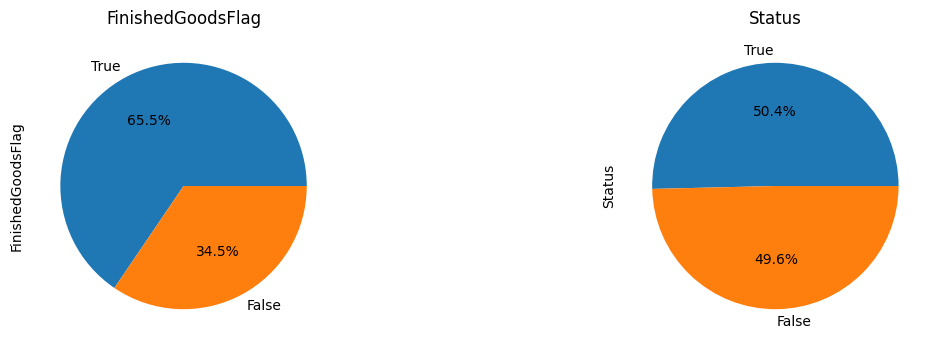

In [67]:
#Se crean dos graficos con los datos de FinishedGoodsFlag y Status
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
ax = products['FinishedGoodsFlag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
ax.set_title('FinishedGoodsFlag')
ax=products_true['Status'].isnull().value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
ax.set_title('Status')




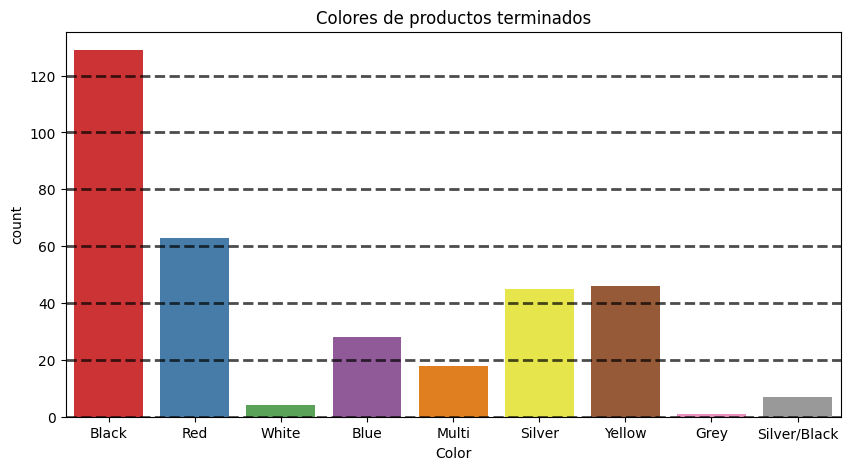

In [68]:
plt.figure(figsize=(10,5))
sns.countplot(x='Color',data=products_true,palette='Set1')
plt.title('Colores de productos terminados')
plt.grid(color='black', linestyle='--',linewidth=2, axis='y', alpha=0.7)
plt.show()

Text(0, 0.5, 'Cantidad')

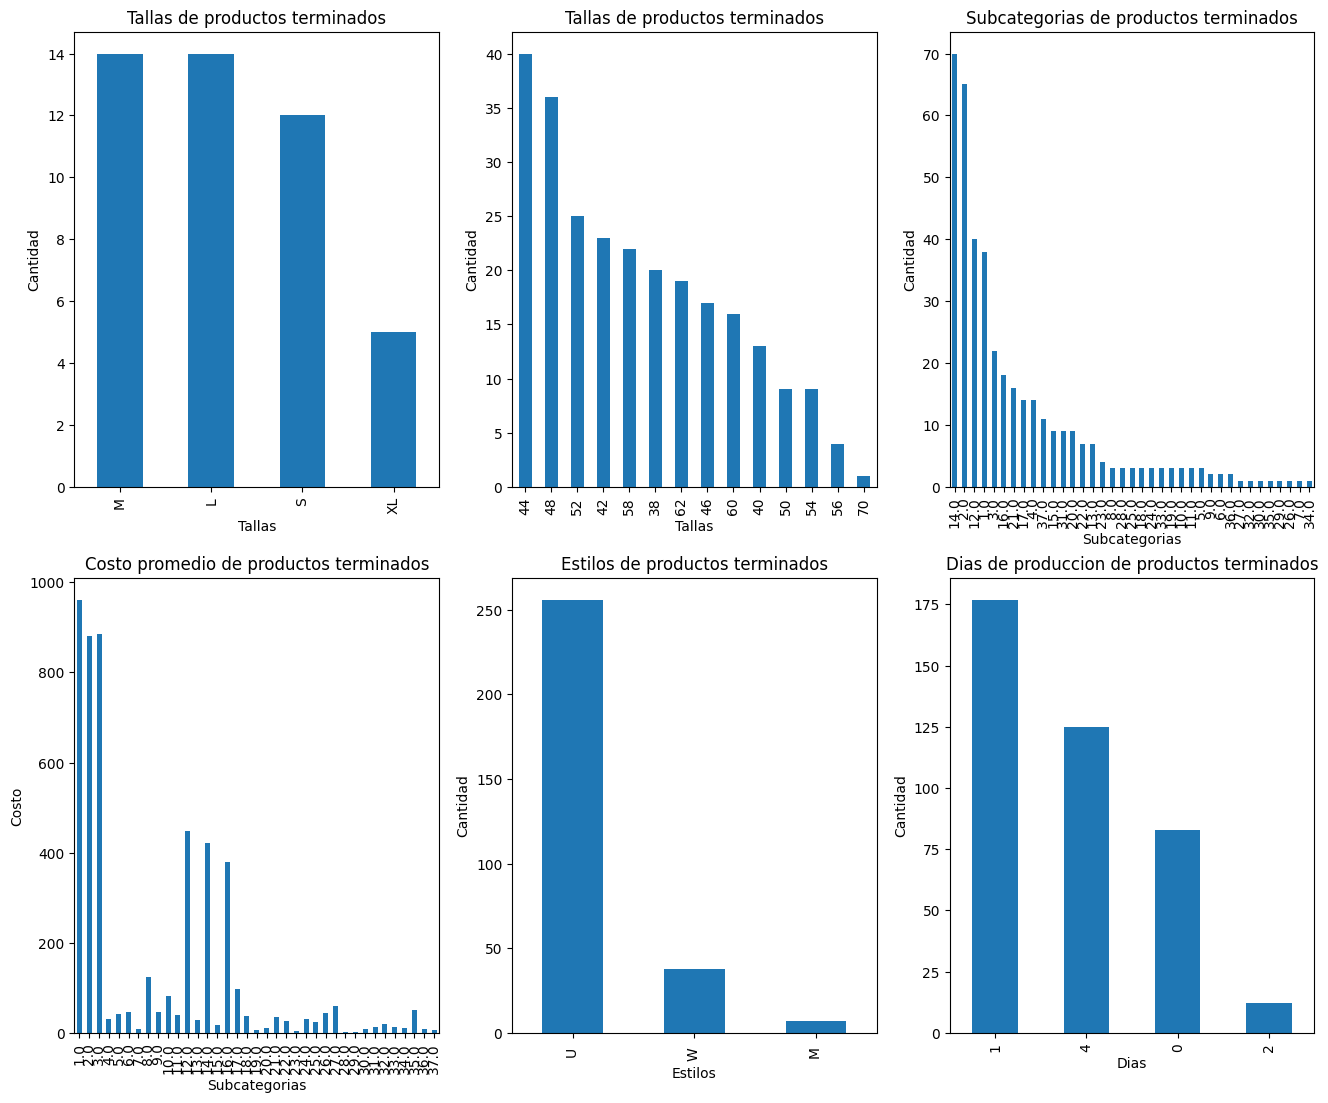

In [69]:
#Se crean dos graficos de datos relevantes
fig, axes = plt.subplots(2, 3, figsize=(16, 13))
ax = products_finished_true['SizeClothes'].value_counts().plot.bar(ax=axes[0,0])
ax.set_title('Tallas de productos terminados')
ax.set_xlabel('Tallas')
ax.set_ylabel('Cantidad')
ax = products_finished_true['SizeParts'].value_counts().plot.bar(ax=axes[0,1])
ax.set_title('Tallas de productos terminados')
ax.set_xlabel('Tallas')
ax.set_ylabel('Cantidad')
ax= products_finished_true['ProductSubcategoryKey'].value_counts().plot.bar(ax=axes[0,2])
ax.set_title('Subcategorias de productos terminados')
ax.set_xlabel('Subcategorias')
ax.set_ylabel('Cantidad')
ax = products_finished_true.groupby('ProductSubcategoryKey')['StandardCost'].mean().plot.bar(ax=axes[1,0])
ax.set_title('Costo promedio de productos terminados')
ax.set_xlabel('Subcategorias')
ax.set_ylabel('Costo')
ax = products_finished_true['Style'].value_counts().plot.bar(ax=axes[1,1])
ax.set_title('Estilos de productos terminados')
ax.set_xlabel('Estilos')
ax.set_ylabel('Cantidad')
ax = products_finished_true['DaysToManufacture'].value_counts().plot.bar(ax=axes[1,2])
ax.set_title('Dias de produccion de productos terminados')
ax.set_xlabel('Dias')
ax.set_ylabel('Cantidad')


In [70]:
#conteo de datos distintos de todas las columnas de la tabla products
products_clean_1.info()
products_clean_1.iloc[:,18:21].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             606 non-null    int64  
 1   ProductAlternateKey    606 non-null    object 
 2   ProductSubcategoryKey  397 non-null    float64
 3   EnglishProductName     606 non-null    object 
 4   StandardCost           395 non-null    float64
 5   FinishedGoodsFlag      606 non-null    bool   
 6   Color                  352 non-null    object 
 7   SafetyStockLevel       606 non-null    int64  
 8   ReorderPoint           606 non-null    int64  
 9   ListPrice              395 non-null    float64
 10  Weight                 282 non-null    float64
 11  DaysToManufacture      606 non-null    int64  
 12  ProductLine            380 non-null    object 
 13  DealerPrice            395 non-null    float64
 14  Class                  330 non-null    object 
 15  Style 

In [72]:
products_clean_1.sample(10)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,EnglishProductName,StandardCost,FinishedGoodsFlag,Color,SafetyStockLevel,ReorderPoint,ListPrice,...,DealerPrice,Class,Style,ModelName,EnglishDescription,StartDate,EndDate,Status,SizeClothes,SizeParts
434,435,FR-R72Y-48,14.0,"ML Road Frame-W - Yellow, 48",300.1188,True,Yellow,500,375,540.7545,...,324.4527,M,W,ML Road Frame-W,Made from the same aluminum alloy as our top-o...,01/07/2012,27/12/2008,NaN,NaN,48
546,547,PD-R853,13.0,HL Road Pedal,35.9596,True,Silver/Black,500,375,80.9900,...,48.5940,H,NaN,HL Road Pedal,Top-of-the-line clipless pedals with adjustabl...,01/07/2013,NaN,Current,NaN,NaN
604,605,BK-R19B-48,2.0,"Road-750 Black, 48",343.6496,True,Black,100,75,539.9900,...,323.9940,L,U,Road-750,Entry level adult bike; offers a comfortable r...,01/07/2013,NaN,Current,NaN,48
57,58,HN-1224,NaN,Hex Nut 7,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
235,236,LJ-0192-X,21.0,"Long-Sleeve Logo Jersey, XL",29.0807,True,Multi,4,3,48.0673,...,28.8404,NaN,U,Long-Sleeve Logo Jersey,Unisex long-sleeve AWC logo microfiber cycling...,01/07/2012,27/12/2008,NaN,XL,NaN
10,11,CR-7833,NaN,Chainring,NaN,False,Black,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
401,402,HB-M918,4.0,HL Mountain Handlebars,53.3999,True,NaN,500,375,120.2700,...,72.1620,H,NaN,HL Mountain Handlebars,Flat bar strong enough for the pro circuit.,01/07/2013,NaN,Current,NaN,NaN
94,95,LI-3800,NaN,Internal Lock Washer 7,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN
498,499,FR-T98U-54,16.0,"HL Touring Frame - Blue, 54",601.7437,True,Blue,500,375,1003.9100,...,602.3460,H,U,HL Touring Frame,The HL aluminum frame is custom-shaped for bot...,01/07/2013,NaN,Current,NaN,54
183,184,RM-R600,NaN,ML Road Rim,NaN,False,NaN,800,600,NaN,...,NaN,M,NaN,NaN,NaN,01/07/2003,NaN,Current,NaN,NaN


In [76]:
#Convertimos formato de fecha de dia mes año a año mes dia de las columnas StartDate y EndDate
products_clean_1['StartDate']=pd.to_datetime(products_clean_1['StartDate'])
products_clean_1['EndDate']=pd.to_datetime(products_clean_1['EndDate'])

/tmp/ipykernel_10886/1836656404.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  products_clean_1['EndDate']=pd.to_datetime(products_clean_1['EndDate'])


In [81]:
products_clean_1.sample(10)

,ProductKey,ProductAlternateKey,ProductSubcategoryKey,EnglishProductName,StandardCost,FinishedGoodsFlag,Color,SafetyStockLevel,ReorderPoint,ListPrice,...,DealerPrice,Class,Style,ModelName,EnglishDescription,StartDate,EndDate,Status,SizeClothes,SizeParts
520,521,SE-T312,15.0,LL Touring Seat/Saddle,12.0413,True,NaN,500,375,27.12,...,16.272,L,NaN,LL Touring Seat/Saddle,"Comfortable, ergonomically shaped gel saddle.",2013-01-07,NaT,Current,NaN,NaN
602,603,BB-9108,5.0,HL Bottom Bracket,53.9416,True,NaN,500,375,121.49,...,72.894,H,NaN,HL Bottom Bracket,Aluminum alloy cups and a hollow axle.,2013-01-07,NaT,Current,NaN,NaN
122,123,LN-1428,NaN,Lock Nut 9,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,2003-01-07,NaT,Current,NaN,NaN
312,313,BK-R93R-52,2.0,"Road-150 Red, 52",2171.2942,True,Red,100,75,3578.27,...,2146.962,H,U,Road-150,This bike is ridden by race winners. Developed...,2011-01-07,2007-12-28,NaN,NaN,52
166,167,MS-6061,NaN,Metal Sheet 1,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,2003-01-07,NaT,Current,NaN,NaN
153,154,LW-9160,NaN,Lock Washer 11,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,2003-01-07,NaT,Current,NaN,NaN
266,267,FR-R38R-52,14.0,"LL Road Frame - Red, 52",187.1571,True,Red,500,375,337.22,...,202.332,L,U,LL Road Frame,"The LL Frame provides a safe comfortable ride,...",2012-01-07,2008-12-27,NaN,NaN,52
16,17,EC-M092,NaN,Mountain End Caps,NaN,False,NaN,1000,750,NaN,...,NaN,NaN,NaN,NaN,NaN,2003-01-07,NaT,Current,NaN,NaN
452,453,SH-M897-M,22.0,"Men's Sports Shorts, M",24.7459,True,Black,4,3,59.99,...,35.994,NaN,M,Men's Sports Shorts,Men's 8-panel racing shorts - lycra with an el...,2012-01-07,2008-12-27,NaN,M,NaN
358,359,BK-M68B-38,1.0,"Mountain-200 Black, 38",1251.9813,True,Black,100,75,2294.99,...,1376.994,H,U,Mountain-200,Serious back-country riding. Perfect for all l...,2013-01-07,NaT,Current,NaN,38


In [83]:
#Creamos un csv con los datos limpios
#products_clean_1.to_csv('/workspaces/Database-project/data/cleaned/Products_Clean_N.csv', index=False)